In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import statistics
import pandas as pd

# To load the data
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

# To define the model
from torch import nn
import torch.nn.functional as F

# To define the optimizer
from torch import optim

# To train the model
import torch
from torch.utils.data import DataLoader, Dataset

/shared-libs/python3.7/py/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Parameters
size_train = 1500
size_val = 250
size_test = 250

epochs = 10

In [ ]:
# Hyperparameters
list_lr = [1e-4, 1e-3, 1e-2, 5e-2, 1e-1]
list_lr_decay = [0]
list_weight_decay = [0, 1e-4, 1e-3, 1e-2]
list_initial_accumulator_value = [0]
list_eps = [1e-10]

# Litterature: lr=0.01, lr_decay=0, weight_decay=0, initial_accumulator_value=0, eps=1e-10

# Load the data

### Load the MNIST dataset

In [ ]:
dataset_train = MNIST(root='data', train=True, transform=ToTensor(), download=True)
dataset_test = MNIST(root='data', train=False, transform=ToTensor(), download=True)

9913344it [00:00, 79961342.77it/s]                             
Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

29696it [00:00, 46458057.29it/s]         
Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

1649664it [00:00, 14288176.42it/s]                             
Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

5120it [00:00, 18401745.06it/s]         
Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



### Separate into train, validation and test sets

In [ ]:
# Train set: first 1500 elements of dataset_train
set_train = []
for i in range(size_train):
    set_train.append(dataset_train[i]) # list of tuple(torch.Tensor, int)

# Validation set: first 250 elements of dataset_test
set_val = []
for i in range(size_val):
    set_val.append(dataset_test[i])

# Test set: following 250 elements of dataset_test
set_test = []
for i in range(size_val, size_val+size_test):
    set_test.append(dataset_test[i])

In [ ]:
print("Number of train samples: ", len(set_train))
print("Number of validation samples: ", len(set_val))
print("Number of test samples: ", len(set_test))

Number of train samples:  1500
Number of validation samples:  250
Number of test samples:  250


### Visualize the data

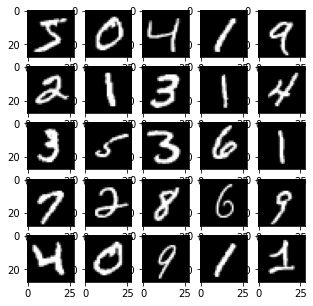

In [ ]:
# Sample 25 MNIST digits from the train dataset
indexes = np.random.randint(0, size_train, size=25)

# Plot the 25 MNIST digits
plt.figure(figsize=(5,5))
for i in range(len(indexes)):
    plt.subplot(5, 5, i + 1)
    image = set_train[i][0].reshape(28,28)
    plt.imshow(image, cmap='gray')
    
plt.show()

# Define the model using Pytorch

### Define the network

https://github.com/rasbt/deeplearning-models/blob/master/pytorch_ipynb/cnn/cnn-resnet18-mnist.ipynb

In [ ]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""

    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # because MNIST is already 1x1 here:
        # disable avg pooling
        #x = self.avgpool(x)
        
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        
        return logits, probas


def resnet18(NUM_CLASSES):
    """Constructs a ResNet-18 model."""

    model = ResNet(block=BasicBlock, 
                   layers=[2, 2, 2, 2],
                   num_classes=NUM_CLASSES,
                   grayscale=True)
    
    return model

### Define the loss function

In [ ]:
criterion = nn.CrossEntropyLoss()

### Define the optimizer

In [ ]:
def define_optimizer(model_run, lr_run=0.01, lr_decay_run=0, weight_decay_run=0, initial_accumulator_value_run=0, eps_run=1e-10):
    
    optimizer = optim.Adagrad(model_run.parameters(), # parameters to optimize [iterable]
                            lr = lr_run, # learning rate [float]
                            lr_decay = lr_decay_run,
                            weight_decay = weight_decay_run, # weight decay (L2 penalty) [float]
                            initial_accumulator_value = initial_accumulator_value_run,
                            eps = eps_run # term added to the denominator to improve numerical stability [float]
                            )

    return optimizer

# Train and evaluate the model

In [ ]:
def compute_accuracy(model, dataloader):

    correct_pred, num_examples = 0, 0

    for it, batch in enumerate(dataloader):

        x, y = batch
            
        logits, probas = model(x)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += len(y)
        correct_pred += (predicted_labels == y).sum()
        
    return correct_pred.float()/num_examples * 100

In [ ]:
def train_model(model, criterion, optimizer, dataloader_train, dataloader_val, epochs):
    
    losses = []
    accs = []
    
    for ep in range(epochs):

        model.train()
        for it, batch in enumerate(dataloader_train):
            x, y = batch
            
            logits = model.forward(x)[0]
            
            loss = criterion(logits, y)
            loss.backward()
            
            optimizer.step()
            optimizer.zero_grad()

        model.eval()
        acc = compute_accuracy(model, dataloader_val)

        print("Epoch {}/{} | Loss = {:.2f} & Acc = {:.4f}".format(ep+1, epochs, float(loss), acc))

        losses.append(float(loss))
        accs.append(acc)
                    
    return losses, accs#, model

In [ ]:
dataloader_train = torch.utils.data.DataLoader(set_train, batch_size = 125, shuffle = True)
dataloader_val = torch.utils.data.DataLoader(set_val, batch_size = 125, shuffle = True)
dataloader_test = torch.utils.data.DataLoader(set_test, batch_size = 125, shuffle = False)

Epoch 1/10 | Loss = 1.53 & Acc = 10.4000
Epoch 2/10 | Loss = 1.01 & Acc = 12.4000
Epoch 3/10 | Loss = 0.68 & Acc = 17.6000
Epoch 4/10 | Loss = 0.51 & Acc = 26.0000
Epoch 5/10 | Loss = 0.50 & Acc = 50.8000
Epoch 6/10 | Loss = 0.37 & Acc = 64.8000
Epoch 7/10 | Loss = 0.32 & Acc = 73.2000
Epoch 8/10 | Loss = 0.26 & Acc = 74.4000
Epoch 9/10 | Loss = 0.27 & Acc = 77.2000
Epoch 10/10 | Loss = 0.21 & Acc = 78.0000
Test accuracy =  79.5999984741211
Epoch 1/10 | Loss = 1.38 & Acc = 8.8000
Epoch 2/10 | Loss = 0.86 & Acc = 17.6000
Epoch 3/10 | Loss = 0.61 & Acc = 24.4000
Epoch 4/10 | Loss = 0.52 & Acc = 29.2000
Epoch 5/10 | Loss = 0.41 & Acc = 52.0000
Epoch 6/10 | Loss = 0.33 & Acc = 77.2000
Epoch 7/10 | Loss = 0.29 & Acc = 82.4000
Epoch 8/10 | Loss = 0.22 & Acc = 84.0000
Epoch 9/10 | Loss = 0.28 & Acc = 84.8000
Epoch 10/10 | Loss = 0.23 & Acc = 85.2000
Test accuracy =  83.20000457763672
Epoch 1/10 | Loss = 1.54 & Acc = 14.0000
Epoch 2/10 | Loss = 0.93 & Acc = 14.4000
Epoch 3/10 | Loss = 0.57 & A

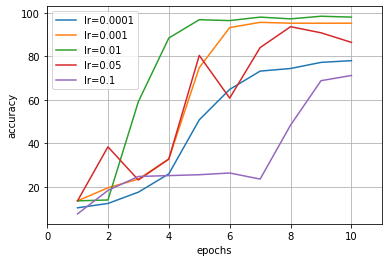

In [ ]:
# To store the accuracy values for each set of hyperparameters
acc_val = np.zeros((len(list_lr),
                len(list_lr_decay),
                len(list_weight_decay),
                len(list_initial_accumulator_value),
                len(list_eps)))

acc_test = np.zeros((len(list_lr),
                len(list_lr_decay),
                len(list_weight_decay),
                len(list_initial_accumulator_value),
                len(list_eps)))

# To store the optimal hyperparameters
lr_star = -1
lr_decay_star = -1
weight_decay_star = -1
initial_accumulator_value_star = -1
eps_star = -1
acc_star = -1


plt.figure()
for idx_lr, lr in enumerate(list_lr):
    for idx_lr_decay, lr_decay in enumerate(list_lr_decay):
        for idx_weight_decay, weight_decay in enumerate(list_weight_decay):
            for idx_initial_accumulator_value, initial_accumulator_value in enumerate(list_initial_accumulator_value):
                for idx_eps, eps in enumerate(list_eps):

                    filename = str(lr)+"_"+str(lr_decay)+"_"+str(weight_decay)+"_"+str(initial_accumulator_value)+"_"+str(eps)

                    # Re-initialize the model and the optimizer parameters
                    model = resnet18(10)
                    optimizer = define_optimizer(model, lr, lr_decay, weight_decay, initial_accumulator_value, eps)

                    # Train the model on the train and validation sets
                    losses, accs = train_model(model, criterion, optimizer, dataloader_train, dataloader_val, epochs)
                    accs = torch.stack(accs).numpy()
                    mean_acc = statistics.mean(accs[epochs-3:epochs]) # average of the last 3 points
                    acc_val[idx_lr, idx_lr_decay, idx_weight_decay, idx_initial_accumulator_value, idx_eps] = mean_acc
                    
                    if lr_decay==0 and weight_decay==0 and initial_accumulator_value==0 and eps==1e-10:
                        acc_val_df = pd.DataFrame(np.c_[np.arange(1, epochs+1)[:,None], accs],
                                                columns=['Epochs', 'Accuracy'])
                        acc_val_df.to_csv('acc_val_' + filename + '.csv', index=False)

                        plt.plot(range(1,epochs+1), accs, label="lr="+str(lr))

                    # Evaluate the model on the test set
                    accuracy_test_set = compute_accuracy(model, dataloader_test)
                    accuracy_test_set = accuracy_test_set.item()
                    print("Test accuracy = ", accuracy_test_set)
                    acc_test[idx_lr, idx_lr_decay, idx_weight_decay, idx_initial_accumulator_value, idx_eps] = accuracy_test_set
                    if accuracy_test_set > acc_star:
                        lr_star = lr
                        lr_decay_star = lr_decay
                        weight_decay_star = weight_decay
                        initial_accumulator_value_star = initial_accumulator_value
                        eps_star = eps
                        acc_star = accuracy_test_set

                    np.save("acc_val.npy", acc_val)
                    np.save("acc_test.npy", acc_test)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.xlim([0,epochs+1])
plt.grid()
#plt.title(filename+" (val set)")
plt.legend()
plt.savefig("lr_tuning.png")



In [ ]:
print("Optimal learning rate = ", lr_star)
print("Optimal learning rate decay = ", lr_decay_star)
print("Optimal weight decay = ", weight_decay_star)
print("Optimal initial accumulator value = ", initial_accumulator_value_star)
print("Optimal epsilon = ", eps_star)
print("Optimal accuracy = ", acc_star)

Optimal learning rate =  0.01
Optimal learning rate decay =  0
Optimal weight decay =  0.001
Optimal initial accumulator value =  0
Optimal epsilon =  1e-10
Optimal accuracy =  96.80000305175781


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=277d1421-3774-402a-b7cf-fa31e85d3168' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>